*MNIST*

# LeNet

![alt text](https://camo.githubusercontent.com/d464ca86de08d7173fcccc38ec0c840a6da02cea/68747470733a2f2f656e676d726b2e636f6d2f77702d636f6e74656e742f75706c6f6164732f323031382f30392f4c654e65745f4f726967696e616c5f496d6167652e6a7067)


![alt text](https://engmrk.com/wp-content/uploads/2018/09/LeNEt_Summary_Table.jpg)

In [0]:
import torch
import random
import numpy as np

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [0]:
import torchvision.datasets

In [0]:
MNIST_train = torchvision.datasets.MNIST('./', download=True, train=True)
MNIST_test = torchvision.datasets.MNIST('./', download=True, train=False)

In [0]:
X_train = MNIST_train.data
y_train = MNIST_train.targets
X_test = MNIST_test.data
y_test = MNIST_test.targets

In [5]:
y_train.shape, y_test.shape

(torch.Size([60000]), torch.Size([10000]))

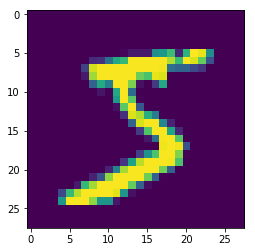

tensor(5)


In [6]:
import matplotlib.pyplot as plt
plt.imshow(X_train[0])
plt.show()
print(y_train[0])

In [7]:
X_train.shape

torch.Size([60000, 28, 28])

In [0]:
X_train = X_train.unsqueeze(1).float()
X_test = X_test.unsqueeze(1).float()  # Чтобы передавать картинку в сеть как трехмерный тензор 

In [9]:
X_train.shape

torch.Size([60000, 1, 28, 28])

In [0]:
class LeNet5(torch.nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()

        self.test_accuracy_history = []
        self.test_loss_history = []
        
        self.conv1 = torch.nn.Conv2d(
            in_channels=1, out_channels=6, kernel_size=5, padding=2)
        self.act1 = torch.nn.Tanh()
        self.pool1 = torch.nn.AvgPool2d(kernel_size=2, stride=2)
        
        self.conv2 = torch.nn.Conv2d(
            in_channels=6, out_channels=16, kernel_size=5, padding=0)
        self.act2 = torch.nn.Tanh()
        self.pool2 = torch.nn.AvgPool2d(kernel_size=2, stride=2)
        
        self.fc1 = torch.nn.Linear(5 * 5 * 16, 120)
        self.act3 = torch.nn.Tanh()
        
        self.fc2 = torch.nn.Linear(120, 84)
        self.act4 = torch.nn.Tanh()
        
        self.fc3 = torch.nn.Linear(84, 10)
        
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)
        
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))  # reshape
        
        x = self.fc1(x)
        x = self.act3(x)
        x = self.fc2(x)
        x = self.act4(x)
        x = self.fc3(x)
        
        return x
    
    def fit(self, X_train, y_train, X_test=None, y_test=None):
        loss = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=1.0e-3)
        
        batch_size = 100

        X_test = X_test.to(device)
        y_test = y_test.to(device)


        for epoch in range(1000):
            order = np.random.permutation(X_train.shape[0])
            for start_index in range(0, X_train.shape[0], batch_size):
                optimizer.zero_grad()

                batch_indexes = order[start_index : start_index + batch_size]

                X_batch = X_train[batch_indexes].to(device)
                y_batch = y_train[batch_indexes].to(device)

                preds = self.forward(X_batch)

                loss_value = loss(preds, y_batch)
                loss_value.backward()

                optimizer.step()
                
            if (X_test is not None) and (y_test is not None):

                test_preds = self.forward(X_test)
                self.test_loss_history.append(loss(test_preds, y_test).data.cpu())  
                # Чтобы не хранить в списке весь граф вычислений берем `.data`
                # И перекладываем на CPU чтобы не засорять память GPU

                accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().data.cpu()
                self.test_accuracy_history.append(accuracy)

                print(accuracy)
            
        return self

In [0]:
net = LeNet5()

In [0]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net = net.to(device)

In [17]:
net.fit(X_train, y_train, X_test, y_test)

tensor(0.9745)
tensor(0.9797)
tensor(0.9862)
tensor(0.9862)
tensor(0.9869)
tensor(0.9883)
tensor(0.9895)


KeyboardInterrupt: ignored

In [18]:
len(list(net.conv2.parameters())[0]) 

16

In [27]:
net.conv2.weight.shape

torch.Size([16, 6, 5, 5])

In [20]:
net.conv2.weight[0]  # Параметры первого фильтра второго сверточного слоя 

tensor([[[ 0.0711, -0.0136,  0.0458, -0.0471,  0.1413],
         [ 0.0274,  0.0477,  0.0281,  0.1336,  0.1518],
         [-0.0806, -0.0701, -0.0961,  0.1610,  0.1347],
         [-0.0359, -0.0961, -0.1640, -0.1288,  0.0359],
         [-0.0955, -0.2206, -0.1321, -0.1312,  0.0627]],

        [[ 0.0672,  0.0611,  0.0287, -0.0459,  0.0720],
         [ 0.0799, -0.0505, -0.0122, -0.0748, -0.0716],
         [ 0.0879,  0.0387,  0.0477, -0.1882, -0.2235],
         [-0.0768, -0.1276, -0.0276, -0.0279, -0.0075],
         [ 0.0798, -0.0277, -0.1868,  0.0232, -0.0049]],

        [[ 0.0910,  0.0955, -0.0650, -0.0842, -0.1121],
         [ 0.1117,  0.0923, -0.0817, -0.0577, -0.1062],
         [ 0.0258, -0.0574, -0.0573, -0.1385, -0.1438],
         [-0.0439, -0.1404, -0.1298, -0.2168, -0.1850],
         [-0.1893, -0.0850, -0.1023, -0.0854, -0.1248]],

        [[-0.0023,  0.0678,  0.0768,  0.1813,  0.1705],
         [-0.0986, -0.0498, -0.1234, -0.1132, -0.1067],
         [ 0.1044,  0.0451, -0.0731, -0.04

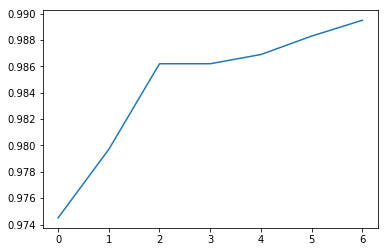

In [24]:
plt.plot(net.test_accuracy_history);

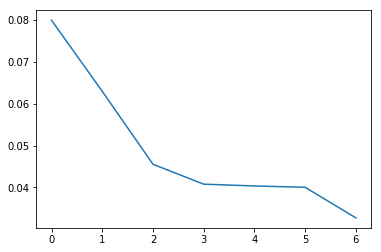

In [30]:
plt.plot(net.test_loss_history);